In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split

import os
import pandas as pd
import numpy as np
import joblib
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import albumentations
import cv2

In [2]:
#https://debuggercafe.com/creating-efficient-image-data-loaders-in-pytorch-for-deep-learning/

In [7]:
class ImageDataset(Dataset):
    
    def __init__(self, path, labels, tfms=None):
        # data loading
        self.X = path
        self.y = labels
        
        # apply augmentations
        # https://github.com/albumentations-team/albumentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
                albumentations.HorizontalFlip(p=1.0),
                albumentations.ShiftScaleRotate(
                    shift_limit=0.3,
                    scale_limit=0.3,
                    rotate_limit=30,
                    p=1.0
                ),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        
    def __getitem__(self, index):
        # dataset[0]
        image = Image.open(self.X[index])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1))
        label = self.y[index]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

        
    def __len__(self):
        # len(dataset)
        return(len(self.X))
    

In [9]:
df = pd.read_csv('/Users/dennislehmann/Documents/HTW_Studium/Semester5/Grundlage_Sozialer_Netze/Old_text_projekt/input/data.csv')
X_ = df.image_path.values
y_ = df.target.values

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
       0.])

In [63]:
#(xtrain, xtest, ytrain, ytest) = (train_test_split(X_, y_,test_size=0.25, random_state=42))


In [11]:
train_data = ImageDataset(X_, y_, 0)

<ipython-input-7-167a3638c042>:36: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


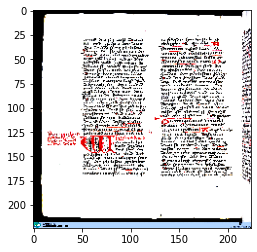

In [14]:
x, y = train_data[0]
image = Image.open(X_[0])
plt.imshow(image)

plt.imshow(x.permute(1, 2, 0))


tensor([[[-1.8097, -1.8782, -1.9467,  ...,  0.9132,  0.9303,  0.9988],
         [-1.9809, -1.7069, -1.8439,  ...,  0.9474,  0.9988,  1.0159],
         [-2.0152, -1.9638, -1.9638,  ...,  0.9817,  1.0159,  1.0159],
         ...,
         [ 0.6392, -1.3987,  1.2557,  ...,  0.6906,  0.6906,  0.6906],
         [ 1.1015, -1.5870, -1.8782,  ...,  0.4679,  0.1939,  0.5022],
         [ 0.6221,  0.7419,  0.6563,  ...,  0.3823,  0.6221, -0.8507]],

        [[-1.7381, -1.8081, -1.8782,  ...,  0.9055,  0.9230,  0.9930],
         [-1.9132, -1.6155, -1.7556,  ...,  0.9405,  0.9930,  1.0105],
         [-1.9307, -1.8957, -1.8957,  ...,  0.9755,  1.0105,  1.0105],
         ...,
         [ 0.8529,  0.6604,  1.9734,  ...,  0.8354,  0.8354,  0.8354],
         [ 0.6604,  0.3277,  0.4503,  ...,  0.6078,  0.3277,  0.6429],
         [ 0.8529,  0.8529,  0.8179,  ...,  0.5203,  0.7654, -0.7402]],

        [[-1.4210, -1.4907, -1.5604,  ...,  0.9668,  0.9842,  1.1237],
         [-1.5953, -1.2990, -1.4559,  ...,  1

In [83]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [84]:
test = ImageDataset(xtrain, ytrain, 0)

In [76]:
X=[]
label=[]

for i in range(xtrain.shape[26]):
    x, y=test[i]
    X.append(x)
    label.append(y)

<ipython-input-61-167a3638c042>:36: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


ValueError: operands could not be broadcast together with shapes (224,224) (3,) (224,224) 

In [36]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [105]:
train_data = torch.utils.data.DataLoader(test, batch_size=100)

In [106]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [107]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

In [108]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [109]:
num_channels, growth_rate = 224, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that haves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [110]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [111]:
def train(net, train_iter, num_epochs, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

In [112]:
lr, num_epochs, batch_size = 0.1, 10, 256
train(net, train_data, num_epochs, lr)

training on cpu


<ipython-input-61-167a3638c042>:36: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)


ValueError: operands could not be broadcast together with shapes (224,224) (3,) (224,224) 

In [94]:
count=0
y_test_porb=net.prediction(xtest)
y_had=torch.max(y_test_porb, 1)[1]
y_test_t=torch.max(torch.Tensor(ytest), 1)[1]

for i in range(y_test_t.shape[0]):
    if y_had[i]==y_test_t[i]:
        count +=1
accuracy=count/y_test_t.shape[0]
accuracy

SyntaxError: unmatched ')' (<ipython-input-94-b26a96af604f>, line 2)